## Método de colocación con PyTorch


A continuación se implementará el método de colocación utilizando un optimizador y la función de autodiferenciación de PyTorch. 

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

## Función de aproximación propuesta

Utilizando una aproximación a la solución de la siguiente forma

$$u_N(x) = \sum_{i=0}^N c_i \phi_i(x) = x (1-x) \sum_{i=0}^N c_i x^i\, ,$$

en donde vemos que esta función satisface las condiciones de frontera.

In [2]:
def funcion_aprox(x, c):
    """Función de aproximación con coeficientes c y variable x"""
    terms = [coef * x**(i + 1) * (1 - x) for i, coef in enumerate(c)]
    return torch.sum(torch.stack(terms), dim=0)


Y el residual estaría dado por

$$R = \frac{d^2 u_N}{dx^2} + u_N + x\, .$$

Considerando el caso de N=3, tenemos que:

$$
-c_0 x^2 + c_0 x - 2c_0 - c_1 x^3 + c_1 x^2 - 6c_1 x + 2c_1 - c_2 x^4 + c_2 x^3 - 12c_2 x^2 + 6c_2 x - c_3 x^5 + c_3 x^4 - 20c_3 x^3 + 12c_3 x^2 + x
$$

In [3]:
def residuo(x, c):
    terms = [
        -c[0]*x**2 + c[0]*x - 2*c[0],
        -c[1]*x**3 + c[1]*x**2 - 6*c[1]*x + 2*c[1],
        -c[2]*x**4 + c[2]*x**3 - 12*c[2]*x**2 + 6*c[2]*x,
        -c[3]*x**5 + c[3]*x**4 - 20*c[3]*x**3 + 12*c[3]*x**2
    ]
    return sum(terms) + x

### Optimización de coeficientes

Optimización de cuatro coeficientes para cuatro valores de $x$.

In [4]:
x = torch.tensor([1/5, 2/5, 3/5, 4/5], requires_grad=True) 

def initialize_coefficients(n):
    std_dev = 1.0 / torch.sqrt(torch.tensor(n, dtype=torch.float32))
    return torch.randn(n) * std_dev

c = initialize_coefficients(4).requires_grad_(True)

def loss_fn(x, c):
    y = residuo(x, c)
    loss = torch.mean(y ** 2)  # Mean squared error
    return loss

optimizer = torch.optim.Adam([c], lr=0.1)

for epoch in range(1_000):  # Number of iterations
    optimizer.zero_grad()  # Clear previous gradients
    loss = loss_fn(x, c)  # Compute loss
    loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters
    
    if epoch % 100 == 0:  # Print progress every 1000 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}, c: {c.data}')

print(f'Optimized c: {c.data}')

Epoch 0, Loss: 0.15892210602760315, c: tensor([ 0.1520,  0.2031, -0.3555,  0.4480])
Epoch 100, Loss: 0.0002551268844399601, c: tensor([ 0.1732,  0.2938, -0.2123,  0.1250])
Epoch 200, Loss: 8.32150035421364e-05, c: tensor([ 0.1841,  0.2084, -0.0608,  0.0215])
Epoch 300, Loss: 0.0009642931399866939, c: tensor([ 0.1859,  0.1821, -0.0262, -0.0083])
Epoch 400, Loss: 3.5261763287053327e-07, c: tensor([ 0.1891,  0.1931, -0.0088, -0.0056])
Epoch 500, Loss: 0.00014587410259991884, c: tensor([ 0.1894,  0.1931, -0.0072, -0.0058])
Epoch 600, Loss: 2.51693222708127e-07, c: tensor([ 0.1884,  0.1889, -0.0105, -0.0085])
Epoch 700, Loss: 6.52890739729628e-05, c: tensor([ 0.1878,  0.1872, -0.0119, -0.0098])
Epoch 800, Loss: 6.644684802381562e-12, c: tensor([ 0.1883,  0.1887, -0.0106, -0.0086])
Epoch 900, Loss: 8.190188964363188e-06, c: tensor([ 0.1885,  0.1891, -0.0102, -0.0083])
Optimized c: tensor([ 0.1883,  0.1887, -0.0106, -0.0087])


Gráfica de la predición obtenido.

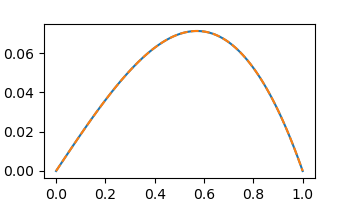

In [5]:
x = torch.linspace(0, 1, steps=100)  # Crea un tensor con 100 puntos equidistantes entre 0 y 1
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x
y_true.detach().numpy()
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x,y_pred)
plt.plot(x,y_true,'--')
plt.show()

Gráfica del residuo obtenido luego de la optimización.

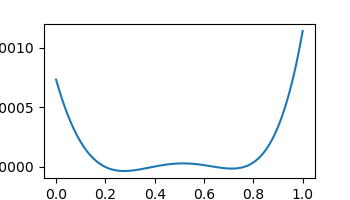

In [6]:
x.requires_grad_(True)
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x.detach().numpy(),residuo(x, c).detach().numpy())
plt.show()

Cálculo del error relativo.

In [7]:
np.linalg.norm(y_pred-y_true.detach().numpy(),2)/np.linalg.norm(y_true,2)

7.583042e-05

## Utilizando diferenciación automática


En lugar de calcular el residuo análiticamente se obtiene con diferenciación automática.

In [8]:
def funcion_aprox(x, c):
    """Función de aproximación con coeficientes c y variable x"""
    terms = [coef * x**(i + 1) * (1 - x) for i, coef in enumerate(c)]
    return torch.sum(torch.stack(terms), dim=0)

def derivative(dy, x, order=1):
    for _ in range(order):
        dy = torch.autograd.grad(dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True)[0]
    return dy

def residuo(x, c):
    return derivative(funcion_aprox(x, c), x, order=2) + funcion_aprox(x, c) + x

def loss_fn(x, c):
    y = residuo(x, c)
    return torch.mean(y ** 2)  # Error cuadrático medio

# Configuración de datos y parámetros
x = torch.tensor([1/5, 2/5, 3/5, 4/5], requires_grad=True)

# Inicialización de coeficientes utilizando Xavier
def initialize_coefficients(n):
    std_dev = 1.0 / torch.sqrt(torch.tensor(n, dtype=torch.float32))
    return torch.randn(n) * std_dev

# Configuración del optimizador
c = initialize_coefficients(4).requires_grad_(True)

In [9]:
# Configuración del optimizador
optimizer = torch.optim.Adam([c], lr=0.1)

# Bucle de entrenamiento
num_epochs = 1_000
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Limpiar gradientes previos
    current_loss = loss_fn(x, c)  # Calcular la pérdida
    current_loss.backward()  # Calcular gradientes
    optimizer.step()  # Actualizar parámetros

    if epoch % 100 == 0:  # Mostrar progreso cada 1000 épocas
        print(f'Epoch {epoch}, Loss: {current_loss.item()}, c: {c.data}')

# Resultados optimizados
print(f'Optimized c: {c.data}') 

Epoch 0, Loss: 5.123162269592285, c: tensor([ 0.4626, -0.1069, -1.0551,  0.0282])
Epoch 100, Loss: 0.001536371186375618, c: tensor([ 0.1483,  0.4622, -0.5592,  0.3451])
Epoch 200, Loss: 0.0012806551530957222, c: tensor([ 0.1481,  0.4419, -0.5202,  0.3240])
Epoch 300, Loss: 0.001059986068867147, c: tensor([ 0.1517,  0.4190, -0.4741,  0.2940])
Epoch 400, Loss: 0.000841969158500433, c: tensor([ 0.1557,  0.3940, -0.4236,  0.2610])
Epoch 500, Loss: 0.0006435870891436934, c: tensor([ 0.1598,  0.3681, -0.3716,  0.2271])
Epoch 600, Loss: 0.0004740459844470024, c: tensor([ 0.1639,  0.3427, -0.3204,  0.1936])
Epoch 700, Loss: 0.00033665134105831385, c: tensor([ 0.1677,  0.3184, -0.2716,  0.1618])
Epoch 800, Loss: 0.000230519610340707, c: tensor([ 0.1713,  0.2960, -0.2265,  0.1323])
Epoch 900, Loss: 0.00015214949962683022, c: tensor([ 0.1745,  0.2759, -0.1860,  0.1059])
Optimized c: tensor([ 0.1773,  0.2584, -0.1507,  0.0829])


Gráfica de la predicción obtenida.

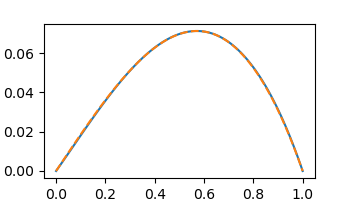

In [10]:
x = torch.linspace(0, 1, steps=100)  # Crea un tensor con 100 puntos equidistantes entre 0 y 1
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x,y_pred)
plt.plot(x,y_true,'--')
plt.show()

Gráfica el residuo obtenido luego de la optimización.

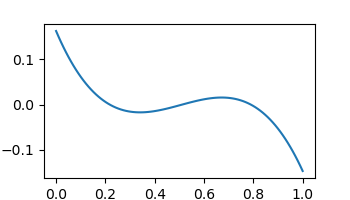

In [11]:
x.requires_grad_(True)
fig = plt.figure(figsize=(3.5, 2.0))
plt.plot(x.detach().numpy(),residuo(x, c).detach().numpy())
plt.show()

Cálculo del error relativo para la apróximación con diferenciación automática.

In [12]:
np.linalg.norm(y_pred-y_true.detach().numpy(),2)/np.linalg.norm(y_true,2)

0.0049805017